In [364]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import tensorflow_addons as tfa
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn import model_selection

In [365]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

In [366]:
df= pd.read_csv('train.csv')

### Preliminary Data Analysis

In [367]:
df.head()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
0,0,212990.0,0.642286,0.856520,0.707073,0.002001,10.0,NaN,-5.619088,0,0.082570,158.386236,4,0.734642,0
1,1,NaN,0.054866,0.733289,0.835545,0.000996,8.0,0.436428,-5.236965,1,0.127358,102.752988,3,0.711531,1
2,2,193213.0,NaN,0.188387,0.783524,-0.002694,5.0,0.170499,-4.951759,0,0.052282,178.685791,3,0.425536,0
3,3,249893.0,0.488660,0.585234,0.552685,0.000608,0.0,0.094805,-7.893694,0,0.035618,128.715630,3,0.453597,0
4,4,165969.0,0.493017,NaN,0.740982,0.002033,10.0,0.094891,-2.684095,0,0.050746,121.928157,4,0.741311,0


In [368]:
#song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness and loudness have about 10%missing data
df.describe()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
count,40000.00000,35899.000000,36008.000000,35974.000000,36025.000000,36015.000000,35935.000000,35914.000000,36043.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,19999.50000,193165.847572,0.276404,0.570951,0.683932,0.036527,5.042605,0.198514,-7.407596,0.321150,0.094107,116.562815,3.394375,0.580645,0.364400
std,11547.14972,45822.127679,0.297928,0.190010,0.212662,0.150024,3.372728,0.151670,3.877198,0.466924,0.083591,26.167911,0.524405,0.237351,0.481268
min,0.00000,25658.000000,-0.013551,0.043961,-0.001682,-0.004398,0.000000,0.027843,-32.117911,0.000000,0.015065,62.055779,2.000000,0.013398,0.000000
25%,9999.75000,166254.500000,0.039618,0.424760,0.539276,0.000941,2.000000,0.111796,-9.578139,0.000000,0.038500,96.995309,3.000000,0.398669,0.000000
50%,19999.50000,186660.000000,0.140532,0.608234,0.704453,0.001974,5.000000,0.135945,-6.345413,0.000000,0.055881,113.795959,3.000000,0.598827,0.000000
75%,29999.25000,215116.000000,0.482499,0.718464,0.870503,0.003225,8.000000,0.212842,-4.620711,1.000000,0.118842,128.517383,4.000000,0.759635,1.000000
max,39999.00000,491671.000000,1.065284,0.957131,1.039741,1.075415,11.000000,1.065298,-0.877346,1.000000,0.560748,219.163578,5.000000,1.022558,1.000000


In [370]:
#A function to help with plotting and analysis of data
def plot(col):
    mean=df[col].mean()
    median=df[col].median()
    maxi=df[col].max()
    mini=df[col].min()
    graph = df[col].plot.kde()  
    print('Mean: ',mean, '\nMedian: ',median,'\nrange: ',str(mini)+' to '+str(maxi))

In [371]:
#Define a robust scaler so that scaling is immune to outliers
scaler = RobustScaler()

### Perform distribution analysis on the columns

Mean:  0.2764044303879504 
Median:  0.14053234888623756 
range:  -0.0135511552613696 to 1.0652843610501974


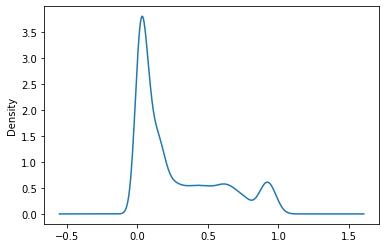

In [372]:
#plot data
plot('acousticness')

Mean:  0.8118131741859592 
Median:  0.8286531388444478 
range:  0.00018608967084992407 to 1.708194561677983


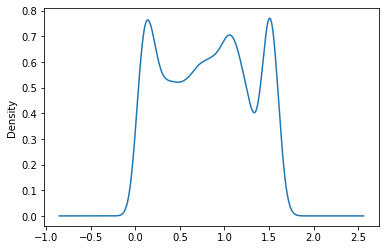

In [374]:
#transform data since we have negative values
df['acousticness']=scaler.fit_transform(np.array(df['acousticness']).reshape(-1,1))
#for an even distribution, we will use mean=median analysis
df['acousticness']=df['acousticness'].apply(lambda x: np.power(x,8/11))
plot('acousticness')

Mean:  0.09410654997438574 
Median:  0.0558807732613924 
range:  0.0150646591183137 to 0.5607483509425971


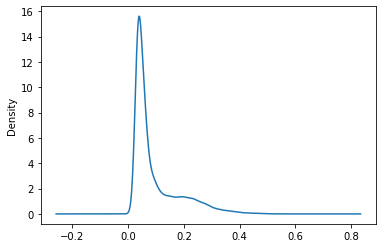

In [375]:
plot('speechiness')

Mean:  40.24795403413316 
Median:  40.76292089456094 
range:  0.14723708971650992 to 151.25445024073431


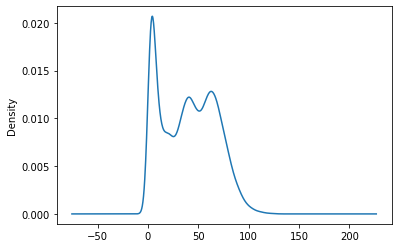

In [376]:
df['speechiness']=df['speechiness'].apply(lambda x: (-np.log(x))**3.5)
plot('speechiness')

Mean:  -0.010671262454285008 
Median:  0.0 
range:  -0.8416475989963758 to 2.2896310408185827


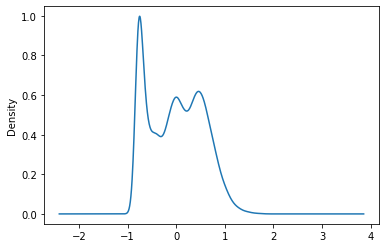

In [377]:
#apply fit transform
df['speechiness']=scaler.fit_transform(np.array(df['speechiness']).reshape(-1,1))
plot('speechiness')

Mean:  0.19851369124259632 
Median:  0.13594518271937028 
range:  0.0278431130171187 to 1.0652980309790911


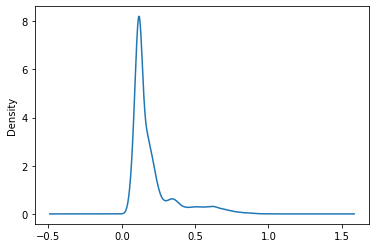

In [378]:
#liveness
plot('liveness')

Mean:  -1.811978340393227 
Median:  -1.9955035427480503 
range:  -3.581169631623469 to 0.0632546013080379


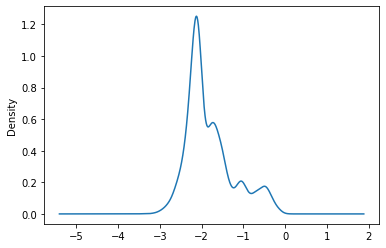

In [379]:
df['liveness']=df['liveness'].apply(lambda x: np.log(x))
plot('liveness')

Mean:  0.036526755987754234 
Median:  0.0019744766301669 
range:  -0.0043980509966391 to 1.0754146806463265


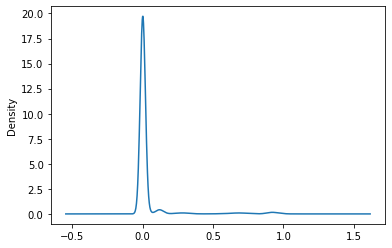

In [380]:
#instrumentalness
plot('instrumentalness')

Mean:  0.5283280350590868 
Median:  0.5059600176837412 
range:  0.1696294487006347 to 1.0081112008301398


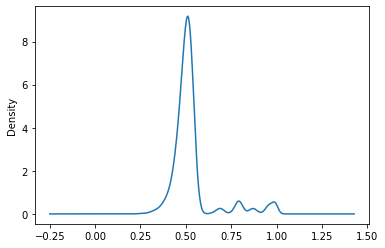

In [381]:
#instrumentalness
df['instrumentalness']=df['instrumentalness'].apply(lambda x: np.power(x,1/9))
plot('instrumentalness')

Mean:  0.6839319477138393 
Median:  0.7044533182633863 
range:  -0.0016822004137934 to 1.0397413046716637


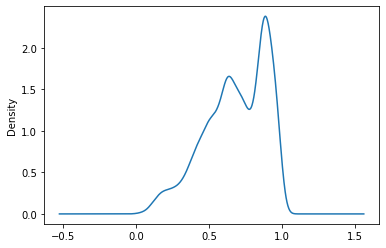

In [382]:
#energy
plot('energy')

Mean:  0.5129867800416463 
Median:  0.49625447761229585 
range:  2.829798232166686e-06 to 1.0810619806403334


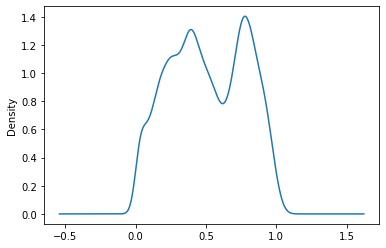

In [383]:
df['energy']=df['energy'].apply(lambda x: x**2)
plot('energy')

Mean:  -7.407596207923781 
Median:  -6.345412615480568 
range:  -32.117910852313194 to -0.8773458492126069


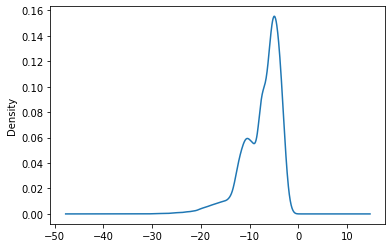

In [384]:
#loudness
plot('loudness')

Mean:  3.759898824570026 
Median:  3.695464258145138 
range:  -0.261708018973908 to 6.938827690010741


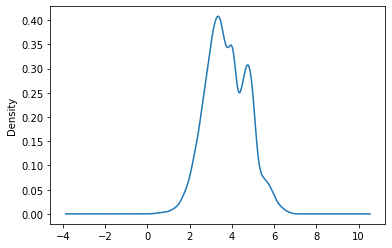

In [385]:
df['loudness']=df['loudness'].apply(lambda x: np.power(x,2))
df['loudness']=df['loudness'].apply(lambda x: np.log(x))
plot('loudness')

Mean:  116.5628148814794 
Median:  113.79595942988647 
range:  62.05577907947696 to 219.16357815182727


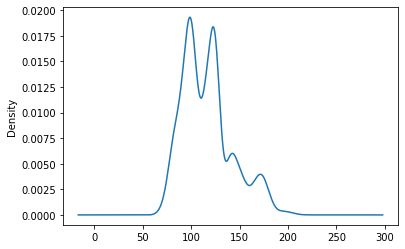

In [386]:
plot('tempo')

### Data Imputations

In [388]:
#Filling missing values (10% of the data) using iterative imputer
col_list=df.columns
imp_mean = IterativeImputer(random_state=27)
df=imp_mean.fit_transform(df)
df=pd.DataFrame(df,columns=col_list)

### Define a function performing complete Data Preprocessing

In [422]:
def preprocess_data(df): #dtype represents test or train
    
    #Data transformations due to distribution analysis
    #use scaler to fit_transform data if necessary
    #for an even distribution, we will use mean=median analysis
    df['acousticness']=scaler.fit_transform(np.array(df['acousticness']).reshape(-1,1))
    df['acousticness']=df['acousticness'].apply(lambda x: np.power(x,8/11))
    #for speechiness
    df['speechiness']=df['speechiness'].apply(lambda x: (-np.log(x))**3.5)
    #for liveness
    df['liveness']=df['liveness'].apply(lambda x: np.log(x))
    #for instrumentalness
    df['instrumentalness']=df['instrumentalness'].apply(lambda x: np.power(x,1/9))
    #for energy
    df['energy']=df['energy'].apply(lambda x: x**2)
    #for loudness
    df['loudness']=df['loudness'].apply(lambda x: np.power(x,2))
    df['loudness']=df['loudness'].apply(lambda x: np.log(x))
    
    #Filling missing values (10% of the data) using iterative imputer
    col_list=df.columns
    imp_mean = IterativeImputer(random_state=27)
    df=imp_mean.fit_transform(df)
    df=pd.DataFrame(df,columns=col_list)
    #key has been imputed with decimal values, round off these values
    df['key']=df['key'].apply(lambda x: round(x,0))
    
    #3. xgboost cannot handle categorical variables, so we encode each variable to the probability of it being True
    # Suppose time_signature 2.0 has song_popularity=1 in 20 instances and song_popularity=0 in 40,
    # The probability variable will turn every instance of time_signature 2.0 to 20/(20+40) = 0.33
    
    #dummy dataframes containing only data with popularity 0 or 1
    dummy_df_1=df.loc[df.song_popularity==1]
    dummy_df_0=df.loc[df.song_popularity==0]

    #probability encoding for 'key' label encoding
    d1=dummy_df_1.groupby(['key'])['song_popularity'].size()
    d0=dummy_df_0.groupby(['key'])['song_popularity'].size()
    labels= dict(d1/(d1+d0))
    df.key.replace(labels.keys(),labels.values(),inplace=True)
    
    #probability encoding for 'time_signature'
    d1=dummy_df_1.groupby(['time_signature'])['song_popularity'].size()
    d0=dummy_df_0.groupby(['time_signature'])['song_popularity'].size()
    labels=dict(d1/(d1+d0))
    df.time_signature.replace(labels.keys(),labels.values(),inplace=True)
    return df

### Training the data

In [423]:
train = pd.read_csv('train.csv')

In [424]:
train = preprocess_data(train)

In [425]:
train.head()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
0,0.0,212990.000000,1.095017,0.856520,0.499952,0.501358,0.382613,-1.701936,3.452339,0.0,24.502306,158.386236,0.355801,0.734642,0.0
1,1.0,194717.510171,0.450500,0.733289,0.698135,0.463935,0.380119,-0.829132,3.311484,1.0,12.562848,102.752988,0.371222,0.711531,1.0
2,2.0,193213.000000,0.724191,0.188387,0.613909,0.550993,0.338964,-1.769028,3.199486,0.0,44.151877,178.685791,0.371222,0.425536,0.0
3,3.0,249893.000000,0.839393,0.585234,0.305461,0.439197,0.354396,-2.355932,4.132128,0.0,67.732566,128.715630,0.371222,0.453597,0.0
4,4.0,165969.000000,0.847021,0.558400,0.549054,0.502236,0.382613,-2.355026,1.974687,0.0,45.732615,121.928157,0.355801,0.741311,0.0


In [463]:
#perform the test train split
def split(df):
    seed=np.random.randint(100)
    X=np.array(df[col_list[1:-1]])
    Y=np.array(df[col_list[-1:]])

    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.20,random_state=seed)
    return X_train,X_test,y_train,y_test

In [432]:
#to ignore the error messages invoked by the xgboost classifier
xgb.set_config(verbosity=0)
#We will train the best parameters on xg_boost and test the training using the test data

In [456]:
final_parameters=dict()
score_history=[]

In [457]:
#class imabalace for xgb training
classes=train.song_popularity.value_counts()
scale_pos_weight=classes[0]/classes[1]
final_parameters['scale_pos_weight']=scale_pos_weight
scale_pos_weight

1.7442371020856202

In [458]:
#xg_boost hyperparameter tuning starts here
#step 1: tune learning_rate and n_estimators
best_parameters = [0.0,0.0]
max_score,prev_score=0.0,0.0
X_train,X_test,y_train,y_test=split(train)
lrs=np.power(10,-1*(np.random.rand(2500)*2+1))
for i in range(2500):
    print('iteration:',i)
    lr = lrs[i]
    n_est = np.random.randint(150,1000)#between 150 and 1000
    xg_cf = xgb.XGBClassifier(objective='binary:logistic',base_score=0.5,metrics={'logloss','auc'},booster='gbtree',
                              use_label_encoder=False,scale_pos_weight=final_parameters['scale_pos_weight'],
                              learning_rate=lr,n_estimators=n_est)
    xg_cf.fit(X_train,np.ravel(y_train))
    score=xg_cf.score(X_test,y_test)
    if max_score<score:
        best_parameters=[lr,n_est]
        max_score = score
print(max_score,best_parameters)

final_parameters['learning_rate']=best_parameters[0]
final_parameters['n_estimators']=best_parameters[1]
score_history.append(score)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
it

iteration: 554
iteration: 555
iteration: 556
iteration: 557
iteration: 558
iteration: 559
iteration: 560
iteration: 561
iteration: 562
iteration: 563
iteration: 564
iteration: 565
iteration: 566
iteration: 567
iteration: 568
iteration: 569
iteration: 570
iteration: 571
iteration: 572
iteration: 573
iteration: 574
iteration: 575
iteration: 576
iteration: 577
iteration: 578
iteration: 579
iteration: 580
iteration: 581
iteration: 582
iteration: 583
iteration: 584
iteration: 585
iteration: 586
iteration: 587
iteration: 588
iteration: 589
iteration: 590
iteration: 591
iteration: 592
iteration: 593
iteration: 594
iteration: 595
iteration: 596
iteration: 597
iteration: 598
iteration: 599
iteration: 600
iteration: 601
iteration: 602
iteration: 603
iteration: 604
iteration: 605
iteration: 606
iteration: 607
iteration: 608
iteration: 609
iteration: 610
iteration: 611
iteration: 612
iteration: 613
iteration: 614
iteration: 615
iteration: 616
iteration: 617
iteration: 618
iteration: 619
iteration:

iteration: 1094
iteration: 1095
iteration: 1096
iteration: 1097
iteration: 1098
iteration: 1099
iteration: 1100
iteration: 1101
iteration: 1102
iteration: 1103
iteration: 1104
iteration: 1105
iteration: 1106
iteration: 1107
iteration: 1108
iteration: 1109
iteration: 1110
iteration: 1111
iteration: 1112
iteration: 1113
iteration: 1114
iteration: 1115
iteration: 1116
iteration: 1117
iteration: 1118
iteration: 1119
iteration: 1120
iteration: 1121
iteration: 1122
iteration: 1123
iteration: 1124
iteration: 1125
iteration: 1126
iteration: 1127
iteration: 1128
iteration: 1129
iteration: 1130
iteration: 1131
iteration: 1132
iteration: 1133
iteration: 1134
iteration: 1135
iteration: 1136
iteration: 1137
iteration: 1138
iteration: 1139
iteration: 1140
iteration: 1141
iteration: 1142
iteration: 1143
iteration: 1144
iteration: 1145
iteration: 1146
iteration: 1147
iteration: 1148
iteration: 1149
iteration: 1150
iteration: 1151
iteration: 1152
iteration: 1153
iteration: 1154
iteration: 1155
iteratio

iteration: 1607
iteration: 1608
iteration: 1609
iteration: 1610
iteration: 1611
iteration: 1612
iteration: 1613
iteration: 1614
iteration: 1615
iteration: 1616
iteration: 1617
iteration: 1618
iteration: 1619
iteration: 1620
iteration: 1621
iteration: 1622
iteration: 1623
iteration: 1624
iteration: 1625
iteration: 1626
iteration: 1627
iteration: 1628
iteration: 1629
iteration: 1630
iteration: 1631
iteration: 1632
iteration: 1633
iteration: 1634
iteration: 1635
iteration: 1636
iteration: 1637
iteration: 1638
iteration: 1639
iteration: 1640
iteration: 1641
iteration: 1642
iteration: 1643
iteration: 1644
iteration: 1645
iteration: 1646
iteration: 1647
iteration: 1648
iteration: 1649
iteration: 1650
iteration: 1651
iteration: 1652
iteration: 1653
iteration: 1654
iteration: 1655
iteration: 1656
iteration: 1657
iteration: 1658
iteration: 1659
iteration: 1660
iteration: 1661
iteration: 1662
iteration: 1663
iteration: 1664
iteration: 1665
iteration: 1666
iteration: 1667
iteration: 1668
iteratio

iteration: 2120
iteration: 2121
iteration: 2122
iteration: 2123
iteration: 2124
iteration: 2125
iteration: 2126
iteration: 2127
iteration: 2128
iteration: 2129
iteration: 2130
iteration: 2131
iteration: 2132
iteration: 2133
iteration: 2134
iteration: 2135
iteration: 2136
iteration: 2137
iteration: 2138
iteration: 2139
iteration: 2140
iteration: 2141
iteration: 2142
iteration: 2143
iteration: 2144
iteration: 2145
iteration: 2146
iteration: 2147
iteration: 2148
iteration: 2149
iteration: 2150
iteration: 2151
iteration: 2152
iteration: 2153
iteration: 2154
iteration: 2155
iteration: 2156
iteration: 2157
iteration: 2158
iteration: 2159
iteration: 2160
iteration: 2161
iteration: 2162
iteration: 2163
iteration: 2164
iteration: 2165
iteration: 2166
iteration: 2167
iteration: 2168
iteration: 2169
iteration: 2170
iteration: 2171
iteration: 2172
iteration: 2173
iteration: 2174
iteration: 2175
iteration: 2176
iteration: 2177
iteration: 2178
iteration: 2179
iteration: 2180
iteration: 2181
iteratio

In [471]:
#step 2: quickly tune max_depth and min_child_weight 
best_parameters = [0.0,0.0]
max_score,prev_score=0.0,0.0
X_train,X_test,y_train,y_test=split(train)
for i in range(1000):
    print('iteration:',i)
    md = np.random.randint(5,50) #range of max depth
    mcw = np.random.randint(1,100) #range of min_child_weight
    xg_cf = xgb.XGBClassifier(objective='binary:logistic',base_score=0.5,metrics={'logloss','auc'},booster='gbtree',
                              use_label_encoder=False,scale_pos_weight=final_parameters['scale_pos_weight'],
                              learning_rate=final_parameters['learning_rate'],n_estimators=final_parameters['n_estimators'],
                              max_depth=md,min_child_weight=mcw)
    xg_cf.fit(X_train,np.ravel(y_train))
    score=xg_cf.score(X_test,y_test)
    if max_score<score:
        best_parameters=[md,mcw]
        max_score = score
        print(score)
    #stop training if the score does not change within a 100 iterations
    if i%100 ==0:
        if max_score!=prev_score:
            prev_score=max_score
        else: break
print(max_score,best_parameters)
final_parameters['max_depth']=best_parameters[0]
final_parameters['min_child_weight']=best_parameters[1]
score_history.append(score)

iteration: 0
0.5925
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
0.59375
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
0.595875
iteration: 19
iteration: 20
0.602625
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 

In [472]:
#Step 3: tune gamma
best_parameters=[0.0]
max_score,prev_score=0.0,0.0
X_train,X_test,y_train,y_test=split(train)
#list of gammas
gs=np.random.rand(500)/2
for i in range(500):
    print('iteration:',i)
    g=gs[i]
    xg_cf = xgb.XGBClassifier(objective='binary:logistic',base_score=0.5,metrics={'logloss','auc'},booster='gbtree',
                              use_label_encoder=False,scale_pos_weight=final_parameters['scale_pos_weight'],
                              learning_rate=final_parameters['learning_rate'],n_estimators=final_parameters['n_estimators'],
                              max_depth=final_parameters['max_depth'],min_child_weight=final_parameters['min_child_weight'],
                              gamma=g)
    xg_cf.fit(X_train,np.ravel(y_train))
    score=xg_cf.score(X_test,y_test)
    if max_score<score:
        best_parameters=[g]
        max_score = score
        print(score)
    #stop training if the score does not change within a 100 iterations
    if i%100 ==0:
        if max_score!=prev_score:
            prev_score=max_score
        else: break
print(max_score,best_parameters)
final_parameters['gamma']=best_parameters[0]
score_history.append(score)

iteration: 0
0.600375
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
0.602125
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
0.604625
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
0.605875
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteratio

In [473]:
#step 4: tune subsample and colsample_bytree
best_parameters=[0.0,0.0]
max_score,prev_score=0.0,0.0
X_train,X_test,y_train,y_test=split(train)
#sss- subsamples, cbs- colsample by trees list
sss=np.random.rand(200)/2 +0.5
cts=np.random.rand(200)/2 +0.5
for i in range(200):
    print('iteration:',i)
    ss=sss[i]
    ct=cts[i]
    xg_cf = xgb.XGBClassifier(objective='binary:logistic',base_score=0.5,metrics={'logloss','auc'},booster='gbtree',
                              use_label_encoder=False,scale_pos_weight=final_parameters['scale_pos_weight'],
                              learning_rate=final_parameters['learning_rate'],n_estimators=final_parameters['n_estimators'],
                              max_depth=final_parameters['max_depth'],min_child_weight=final_parameters['min_child_weight'],
                              gamma=final_parameters['gamma'],subsample=ss,colsample_bytree=ct)
    xg_cf.fit(X_train,np.ravel(y_train))
    score=xg_cf.score(X_test,y_test)
    if max_score<score:
        best_parameters=[ss,ct]
        max_score = score
        print(score)
    #stop training if the score does not change within a 100 iterations
    if i%100 ==0:
        if max_score!=prev_score:
            prev_score=max_score
        else: break
print(max_score,best_parameters)
final_parameters['subsample']=best_parameters[0]
final_parameters['colsample_bytree']=best_parameters[1]
score_history.append(score)

0.59475
0.601875
0.608375
0.610875
0.610875 [0.9103257624647876, 0.6973609571902502]


In [ ]:
#step 5: tune colsample by level and colsample by node
best_parameters=[0.0,0.0]
max_score,prev_score=0.0,0.0
X_train,X_test,y_train,y_test=split(train)
#cls- colsample by levels, cns- colsample by nodes
cls=np.random.rand(200)/2 +0.5
cns=np.random.rand(200)/2 +0.5
for i in range(200):
    print('iteration:',i)
    cl=cls[i]
    cn=cns[i]
    xg_cf = xgb.XGBClassifier(objective='binary:logistic',base_score=0.5,metrics={'logloss','auc'},booster='gbtree',
                              use_label_encoder=False,scale_pos_weight=final_parameters['scale_pos_weight'],
                              learning_rate=final_parameters['learning_rate'],n_estimators=final_parameters['n_estimators'],
                              max_depth=final_parameters['max_depth'],min_child_weight=final_parameters['min_child_weight'],
                              gamma=final_parameters['gamma'],subsample=final_parameters['subsample'],
                              colsample_bytree=final_parameters['colsample_bytree'],colsample_bylevel=cl,colsample_bynode=cn)
    xg_cf.fit(X_train,np.ravel(y_train))
    score=xg_cf.score(X_test,y_test)
    if max_score<score:
        best_parameters=[cl,cn]
        max_score = score
        print(score)
    #stop training if the score does not change within a 100 iterations
    if i%100 ==0:
        if max_score!=prev_score:
            prev_score=max_score
        else: break
print(max_score,best_parameters)
final_parameters['colsample_bylevel']=best_parameters[0]
final_parameters['colsample_bynode']=best_parameters[1]
score_history.append(score)

0.604625
0.608125
0.60925
0.614625


In [ ]:
#step 6                                           : train regularization and lambda parameters
best_parameters=[0.0,0.0]
max_score=0.0
for i in range(50):
    reg_a=0.6 + 0.4*np.randint(0,16)/15 
    reg_l=0.6 + 0.4*np.randint(0,16)/15
    xg_cf = xgb.XGBClassifier(booster='gbtree',metrics={'logloss'},objective='binary:logistic',
                              use_label_encoder=False,learning_rate=best_parameters1[0],n_estimators=best_parameters1[1],
                              max_depth=best_parameters2[0],min_child_weight=best_parameters2[1],gamma=best_parameters3[0],
                              subsample=best_parameters4[0],cosample_bytree=best_parameters4[1],n_jobs=4,
                              importance_type='gain',reg_alpha=reg_a,reg_lambda=reg_l
                              
                              
                             )
    xg_cf.fit(X_train,np.ravel(y_train))
    score=xg_cf.score(X_test,y_test)
    if max_score<score:
        best_parameters=[reg_a,reg_l]
        max_score = score
print(max_score,best_parameters)

In [1034]:
### xgboost classifier
xg_cf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
              colsample_bynode=0.9, colsample_bytree=0.9, gamma=0.02, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=12,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=500, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)


In [1035]:
#final_classifier
xg_cf_final = xgb.XGBClassifier(base_score=0.5,booster='gbtree',metrics={'logloss'},objective='binary:logistic',
                          use_label_encoder=False,learning_rate=best_parameters1[0],n_estimators=best_parameters1[1],
                          max_depth=best_parameters2[0],min_child_weight=best_parameters2[1],gamma=best_parameters3[0],
                          subsample=best_parameters4[0],cosample_bytree=best_parameters4[1],n_jobs=4,importance_type='gain',reg_lambda=1,tree_method='exact'
                         )

In [1009]:
xg_cf_final.fit(X_train,np.ravel(y_train))
score_final=xg_cf_final.score(X_test,y_test)
confusion_final=metrics.confusion_matrix(y_test, xg_cf_final.predict(X_test), labels=[1.0, 0.0])
f1_final=f1_score(xg_cf_final.predict(X_test),y_test)

[05:25:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "cosample_bytree", "metrics" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:25:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [1036]:
xg_cf_complete=xg_cf_final.fit(X,Y)
score_complete=xg_cf_final.score(X,Y)
confusion_commplete=metrics.confusion_matrix(Y, xg_cf_final.predict(X), labels=[1.0, 0.0])
f1_complete=f1_score(xg_cf_final.predict(X),Y)

[20:30:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "cosample_bytree", "metrics" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:30:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [1003]:
print(score_final,confusion_final,f1_final)

0.5411666666666667 [[1303 1667]
 [1086 1944]] 0.486284754618399


In [1037]:
print(score_complete,confusion_commplete,f1_complete)

0.6608553618453948 [[ 8188  6388]
 [ 3786 11637]] 0.616798493408663


In [996]:
xg_cf.fit(X,np.ravel(Y))

[05:18:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
              colsample_bynode=0.9, colsample_bytree=0.9,
              enable_categorical=False, gamma=0.02, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [918]:
xg_score = xg_cf.score(X_test,y_test)
type(xg_score)

numpy.float64

In [917]:
print(metrics.confusion_matrix(y_test, xg_cf.predict(X_test), labels=[1.0, 0.0]))

[[1413 1557]
 [1323 1707]]


In [912]:
len(X_train)

23999

In [913]:
X_train

array([[0.15715147, 0.54494101, 0.00581009, ..., 1.        , 0.03735813,
        0.25908832],
       [0.03209012, 0.78670606, 0.00754004, ..., 0.        , 0.04823268,
        0.2296232 ],
       [0.84132689, 0.35644043, 0.89987883, ..., 0.        , 0.04181525,
        0.16178944],
       ...,
       [0.91350039, 0.53019445, 0.00819965, ..., 0.        , 0.02595831,
        0.16226408],
       [0.03231412, 0.68858572, 0.00573481, ..., 0.        , 0.04765567,
        0.75192959],
       [0.52115504, 0.6576599 , 0.58878936, ..., 0.        , 0.04750143,
        0.25002034]])

In [488]:
df_test = pd.read_csv('test.csv')

In [491]:
df_test.head()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,0,308523.0,0.019845,NaN,0.908939,0.001438,NaN,0.112832,-8.890172,0,0.082714,126.129304,4,0.399620
1,1,200011.0,0.070119,0.731256,0.444655,0.002020,10.0,0.139040,-6.301214,0,0.061685,86.448149,3,0.499424
2,2,279758.0,0.810637,0.568858,0.125466,0.898841,0.0,0.226614,-11.542478,0,0.041868,99.544351,3,0.564951
3,3,249197.0,NaN,0.871789,0.557342,0.000715,4.0,0.325391,-7.905546,1,0.046815,123.063854,4,0.906485
4,4,NaN,0.765568,0.624687,0.710794,0.000346,8.0,0.308284,NaN,0,0.129284,88.703121,3,0.935571


In [739]:
df.describe()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
count,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000
mean,20239.845428,0.359581,0.269317,0.580243,0.681225,0.037120,5.063235,0.163022,-7.434847,0.321677,0.145885,0.347887,3.394513,0.579544,0.485883
std,11700.808598,0.098816,0.277751,0.208706,0.213405,0.137150,3.381617,0.147011,3.880253,0.467128,0.153704,0.167871,0.523911,0.237438,0.499809
min,1.000000,0.000000,0.000000,0.000000,-0.001682,0.000000,0.000000,0.000000,-30.170399,0.000000,0.000000,0.000000,2.000000,0.013398,0.000000
25%,10071.500000,0.301888,0.048577,0.419421,0.538966,0.004937,2.000000,0.078991,-9.595018,0.000000,0.043257,0.222131,3.000000,0.396649,0.000000
50%,20225.000000,0.345696,0.141880,0.622036,0.700129,0.005892,6.000000,0.101881,-6.389789,0.000000,0.075500,0.328578,3.000000,0.598034,0.000000
75%,30413.500000,0.406687,0.462294,0.742441,0.868843,0.007062,8.000000,0.176290,-4.632665,1.000000,0.192090,0.425102,4.000000,0.758508,1.000000
max,39999.000000,1.000000,1.000000,1.000000,1.039741,1.000000,11.000000,1.000000,-0.877346,1.000000,1.000000,1.000000,5.000000,1.022558,1.000000


In [504]:
col_list=['song_duration_ms','tempo','acousticness','danceability','energy','instrumentalness','liveness','loudness','speechiness','audio_valence']
for column in col_list:
    test_df[column] = MinMaxScaler().fit_transform(np.array(test_df[column]).reshape(-1,1))


In [505]:
test_df.describe()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,audio_mode,speechiness,tempo,audio_valence,key_0.0,key_1.0,key_2.0,key_3.0,key_4.0,key_5.0,key_6.0,key_7.0,key_8.0,key_9.0,key_10.0,key_11.0,time_signature_2,time_signature_3,time_signature_4,time_signature_5
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.50000,0.396161,0.780217,0.572614,0.655405,0.038421,0.539878,0.848818,0.323800,0.455136,0.363908,0.560669,0.134300,0.0508,0.105900,0.035200,0.054000,0.070900,0.124600,0.068700,0.072200,0.074900,0.105900,0.003400,0.015800,0.581600,0.397600,0.005000
std,2886.89568,0.110018,0.159340,0.215771,0.210414,0.146041,0.169795,0.069467,0.467948,0.224777,0.171780,0.237352,0.340991,0.2196,0.307725,0.184294,0.226029,0.256671,0.330281,0.252956,0.258832,0.263243,0.307725,0.058213,0.124707,0.493321,0.489426,0.070537
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2499.75000,0.333683,0.678867,0.410729,0.515973,0.004166,0.464332,0.808084,0.000000,0.258624,0.236579,0.379771,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4999.50000,0.379720,0.798927,0.614778,0.671419,0.005187,0.592491,0.853582,0.000000,0.500855,0.343008,0.573082,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,7499.25000,0.447861,0.924918,0.737399,0.840734,0.006361,0.651310,0.902724,1.000000,0.642430,0.439357,0.740470,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,9999.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [798]:
df_dl=test_df
df_dl = df_dl[['song_duration_ms','acousticness','danceability','instrumentalness',"liveness","audio_mode","speechiness",
               "tempo"]]

col_list=df_dl.columns
X=np.array(df_dl[col_list[1:-1]])
Y=np.array(df_dl[col_list[-1:]])
#print(X,Y)

col_list=['song_duration_ms','tempo','acousticness','danceability','instrumentalness','liveness','speechiness']
for column in col_list:
    df[column] = MinMaxScaler().fit_transform(np.array(df[column]).reshape(-1,1))
col_list = df_dl.columns
X_test_df = np.array(df_dl[col_list[1:]])

In [1038]:
y_test_output = xg_cf_complete.predict(X_test_df)

In [1039]:
d1 = pd.Series(list(range(10000))) 
d2 = pd.Series(y_test_output)
y_test_df=pd.concat([d1,d2],join='inner',keys=['id','song_popularity'],axis=1)

,id,song_popularity
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
5,5,1
6,6,1
7,7,1
8,8,1
9,9,0


In [1040]:
y_test_df.to_csv('Submission6.csv',index=None)

In [548]:
#transformations for acousticness
df['acousticness'] = df['acousticness'].apply(lambda x: (np.log(x)))
#transformation for speechiness
df['speechiness'] = df['speechiness'].apply(lambda x: (-np.log(x))**2)
#transformation for liveness
df['liveness'] = df['liveness'].apply(lambda x: -1*np.log(x))
#transformation for loudness

In [718]:
model_history=model.fit(X_train,y_train,epochs=30,validation_data=(X_val,y_val))

Epoch 1/30
750/750 [==============================] - 2s 2ms/step - loss: nan - accuracy: 0.5164 - val_loss: nan - val_accuracy: 0.5015
Epoch 2/30
750/750 [==============================] - 1s 1ms/step - loss: nan - accuracy: 0.5164 - val_loss: nan - val_accuracy: 0.5015
Epoch 3/30
750/750 [==============================] - 1s 1ms/step - loss: nan - accuracy: 0.5164 - val_loss: nan - val_accuracy: 0.5015
Epoch 4/30
750/750 [==============================] - 1s 1ms/step - loss: nan - accuracy: 0.5164 - val_loss: nan - val_accuracy: 0.5015
Epoch 5/30
750/750 [==============================] - 1s 1ms/step - loss: nan - accuracy: 0.5164 - val_loss: nan - val_accuracy: 0.5015
Epoch 6/30
750/750 [==============================] - 1s 1ms/step - loss: nan - accuracy: 0.5164 - val_loss: nan - val_accuracy: 0.5015
Epoch 7/30
750/750 [==============================] - 1s 1ms/step - loss: nan - accuracy: 0.5164 - val_loss: nan - val_accuracy: 0.5015
Epoch 8/30
750/750 [============================

KeyboardInterrupt: 

In [369]:
#deletes about 10000 data points from the class with higher values, thus reducing the imbalance
def delete_imbalanced_classes():
    count=0
    for index, row in df.iterrows():
        #skewed data points, drop data if size of output data class is greater than other class
        #this solves the problem of class imbalance, but will lose about 10000 data which is 25% of total data
        x=df.groupby('song_popularity').size()
        #see which class has a greater value
        greater= 0 if x[0]>x[1] else 1
        if row['song_popularity']==greater:continue
        col_list=['song_duration_ms','acousticness','danceability','instrumentalness',"liveness","audio_mode","speechiness",
                   "tempo","song_popularity"]
        for col in col_list:
            if pd.isnull(row[col]):
                try:
                    df.drop(index,inplace=True,axis=0)
                except:
                    continue
                count+=1
        if count>10000:break
    df=df.reset_index(drop=True)
    df=df.ffill(axis=0)
    df=df.bfill(axis=0)
    return df